# Curriculum Access Logs Time Series Project

## Initial questions to answer

 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
 2. Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 
 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 
 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents? 
 5. At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before? 
 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)? 
 7. Which lessons are least accessed? 
 8. Anything else I should be aware of? 

## Deliverables

- link to GitHub notebook that asks and answers questions - document the work you do to justify findings
- email with the answers to the questions/your findings
    - include the link to your notebook in GitHub
    - attach your slide. 
- be sure that the details you need your need your leader to convey/understand are clearly communicated in the email. 
- Slide should be like an Executive Summary and be in form to present, slide notes for speaking points may also be included 

## Environment Setup

In [1]:
import acquire
import prepare
import wrangle
import summarize
import explore

import numpy as np
import pandas as pd
import math
from datetime import datetime
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics

from scipy.stats import entropy

import matplotlib.dates as mdates #to format dates on our plots

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

explore.set_plotting_defaults()

# Acquire

- read in text dataframes and merge together

In [2]:
df = acquire.run()

Acquire: downloading raw data files...
Acquire: Completed!


# Prepare
- exp will be dataframe that is a time series as index
- exp_not_ts will have index that is not time series

- set 44,840 null cohort values to 0
- set 1 null page_viewed value to 0


In [3]:
exp, exp_not_ts = prepare.run(df)

Prepare: Cleaning acquired data...
Prepare: Completed! Data not split because no modeling at this time. Full dataset returned.


In [4]:
exp.head()

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,9,Friday,26,1,2018


In [5]:
exp_not_ts.head()

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
0,2018-01-26 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
1,2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
3,2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
4,2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,9,Friday,26,1,2018


In [6]:
exp.shape

(719459, 13)

In [7]:
exp[exp.cohort_id == 0]

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2018-01-26 16:46:16,/,48,0,97.105.19.61,0,0,0,0.0,16,Friday,26,1,2018
2018-01-26 16:46:24,spring/extra-features/form-validation,48,0,97.105.19.61,0,0,0,0.0,16,Friday,26,1,2018
2018-01-26 17:54:24,/,48,0,97.105.19.61,0,0,0,0.0,17,Friday,26,1,2018
2018-01-26 18:32:03,/,48,0,97.105.19.61,0,0,0,0.0,18,Friday,26,1,2018
2018-01-26 18:32:17,mysql/relationships/joins,48,0,97.105.19.61,0,0,0,0.0,18,Friday,26,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 16:02:22,java-iii,717,0,136.50.18.157,0,0,0,0.0,16,Monday,2,11,2020
2020-11-02 16:02:26,java-iii/servlets,717,0,136.50.18.157,0,0,0,0.0,16,Monday,2,11,2020
2020-11-02 16:03:50,appendix/further-reading/java/intellij-tomcat-...,727,0,70.94.165.107,0,0,0,0.0,16,Monday,2,11,2020


In [8]:
    
# df['newcolumn']
# df.loc[df['program_id'] == #, 'newcolumn'] = value

# Explore

<AxesSubplot:xlabel='cohort_id', ylabel='hour'>

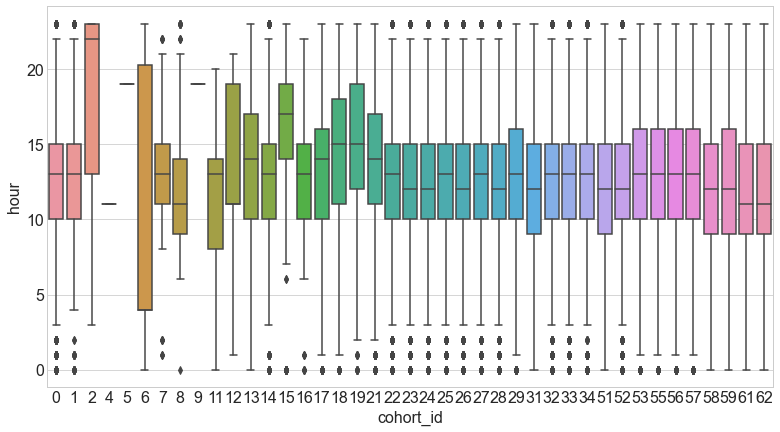

In [9]:
sns.boxplot(data=exp, y='hour', x='cohort_id')